# Exploratory Data Analysis Titanic dataset

The objective of this analysis is to understand the Titanic dataset to help classifying passengers by the target class 'Survived'.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns

In [2]:
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
data=pd.concat([train,test], ignore_index=True, axis=0)

## Section 1: Basic dataset exploration 

From the cells below we can extract some basic conclusions in order to create the final dataset:
* PassengerID should be deleted since it follows a uniform distribution and it doesn't add useful information.
* Pclass could be a useful since it's an indicator of the money the passengers have. We will do a one-hot encoding since there are only three possible classes (1,2 or 3).
* We will delete Name. It could be useful but we want to keep the model simple.
* Sex it's one of the most important features (according to the correlation matrix). Since there are two values (male,female) we will transform it into binary).
* For Age we have missing values that need to be discussed. We will try to input this values. After this step maybe a normalization might be required.
* Sibsp are the number of siblings/spouses aboard the Titanic. For the moment we will leave it without changes.
* Parch are the number of parents/children aboard the Titanic. Will be treated as Sibsp.
* About Ticket, it's a categorical variable with high cardinality and distributed almost uniformly. We will not include it in the model.
* Fare has just one missing value which we will input as the median value of this attribute.
* Cabin is a categorical variable with 11 distinct values and many nulls. Since the cabin number is not relevant apparently we will treated as binary (passenger in cabin 1 else 0).
* Embarked is a categorical variable with three values (therefore one-hot encoding). Also it has two missing values that will be inputed as if they are from the majority class which is 'S' (Southampton).

In [3]:
display(data.head(5))
print(data.info())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None


In [4]:
profile = ProfileReport(data, title='Pandas Profiling Report', explorative=True)
profile

## Section 2: Identifying main variables related to 'Survived'

The objective of this section is to understand the main variables that are related to 'Survived'.

From the numerical variables we identify that rich passengers had more chances to survive and that younger people were more likely to survive.

Categorical variables are giving us a lot of information:
* Class 1 passengers are more likely to survive than Class 3.
* Many women survived while the majority of men died.
* People in Cabin were more likely to survive.
* Passengers embarked in S were more likely to die.

In [5]:
# Deleting unused variables
data=data.drop(["PassengerId","Name","Ticket"], axis=1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0.0,3,male,22.0,1,0,7.2500,NaN,S
1,1.0,1,female,38.0,1,0,71.2833,C85,C
2,1.0,3,female,26.0,0,0,7.9250,NaN,S
3,1.0,1,female,35.0,1,0,53.1000,C123,S
4,0.0,3,male,35.0,0,0,8.0500,NaN,S


In [6]:
for col in data.columns:
    uniques=len(data[col].unique())
    if uniques<=5:
        data[col]=data[col].astype('category')
        print('Changing variable',col,'to categorical.','It has',uniques,'distinct values')

Changing variable Survived to categorical. It has 3 distinct values
Changing variable Pclass to categorical. It has 3 distinct values
Changing variable Sex to categorical. It has 2 distinct values
Changing variable Embarked to categorical. It has 4 distinct values


In [7]:
# Define the target column
target_variable = ["Survived"]
# Define the numerical variables
num_variables = [column for column, datatype in data.dtypes.items() if datatype in (np.int64, np.float64) and column!=target_variable]
# Define the categorical ones
categorical_variables = [column for column in data.columns if column not in target_variable + num_variables]
print(num_variables)
print(categorical_variables)

['Age', 'SibSp', 'Parch', 'Fare']
['Pclass', 'Sex', 'Cabin', 'Embarked']


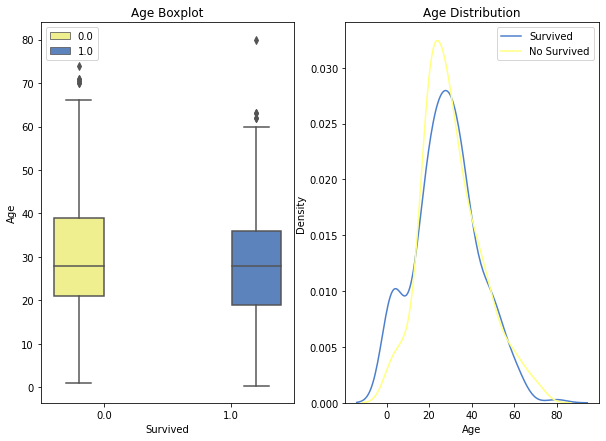

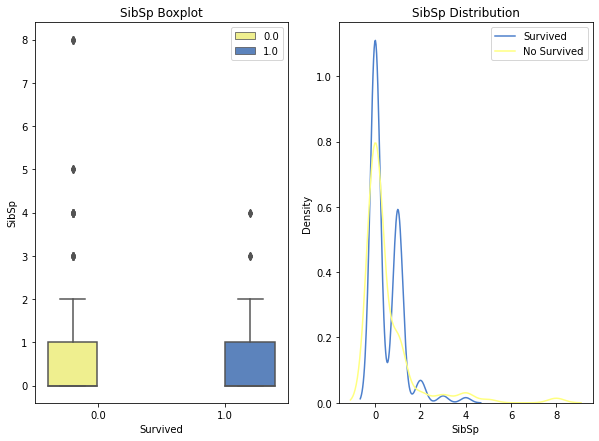

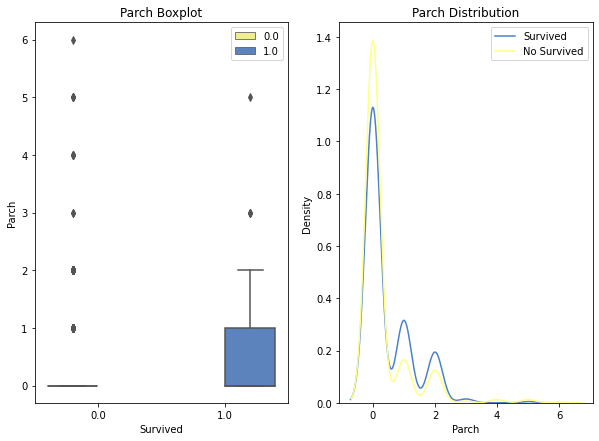

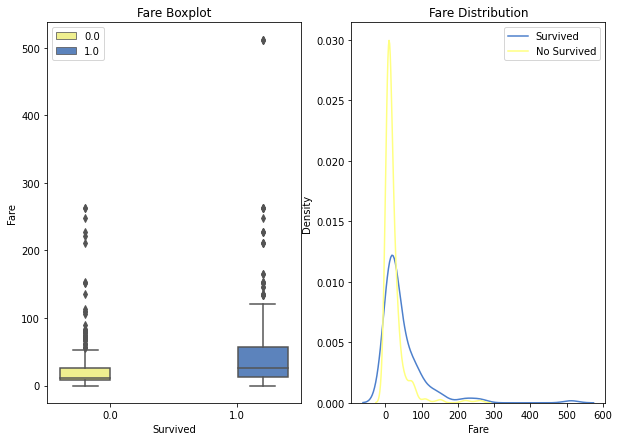

In [8]:
for col in num_variables:
    col_df=data.dropna(subset=["Survived",col])
    surv=col_df[col_df["Survived"]==1]
    no_surv=col_df[col_df["Survived"]==0]
    plt.figure(figsize=(10,7))
    plt.subplot(1,2,1)
    plt.title(col+' Boxplot')
    sns.boxplot(x='Survived',y=col,hue='Survived',data=col_df,palette=sns.color_palette([(1,1,0.5),(0.3,0.5,0.8)]))
    plt.legend(loc="best")
    plt.subplot(1,2,2)
    plt.title(col+' Distribution')
    a=sns.kdeplot(surv[col],color=(0.3,0.5,0.8),label='Survived')
    b=sns.kdeplot(no_surv[col],color=(1,1,0.5),label='No Survived')
    plt.legend()
    plt.show()

In [9]:
data['Cabin'].loc[~data['Cabin'].isnull()] = 1  # not nan
data['Cabin'].loc[data['Cabin'].isnull()] = 0   # nan

C:\Users\Marc\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


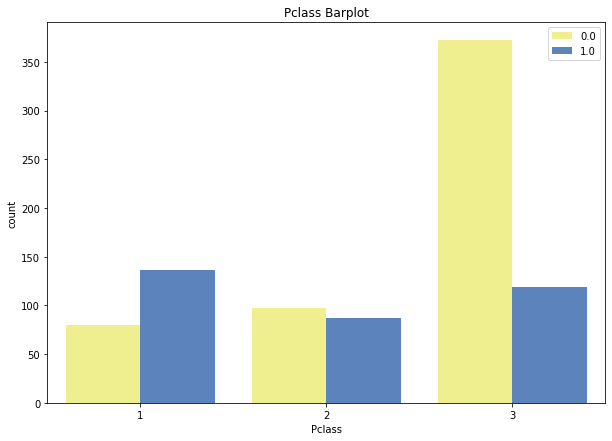

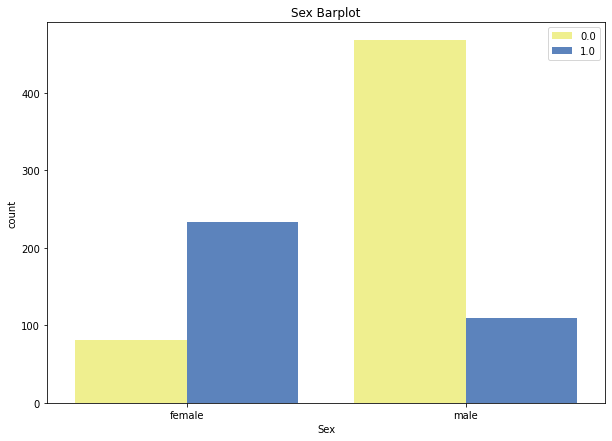

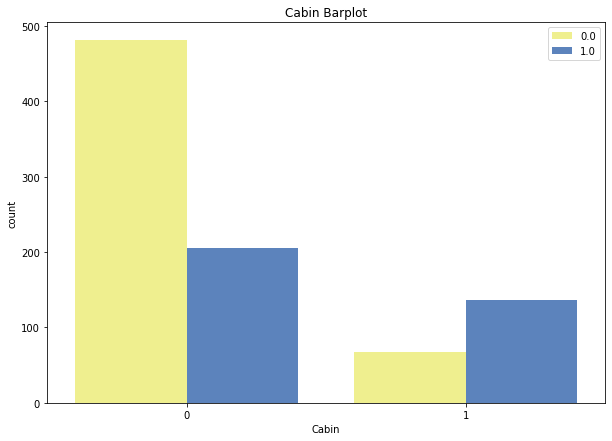

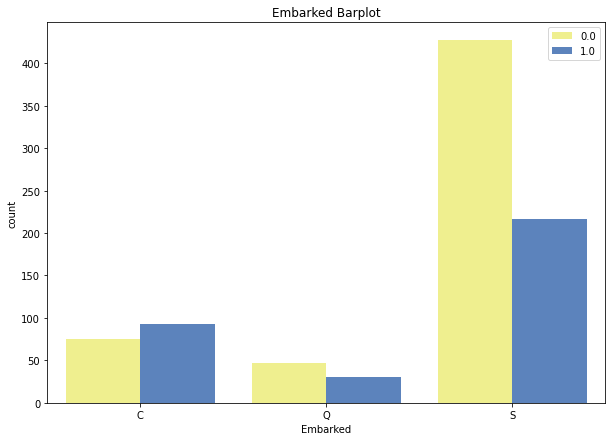

In [10]:
for col in categorical_variables:
    col_df=data.dropna(subset=["Survived",col])
    plt.figure(figsize=(10,7))
    plt.title(col+' Barplot')
    sns.countplot(x=col,hue='Survived',data=col_df,palette=sns.color_palette([(1,1,0.5),(0.3,0.5,0.8)]))
    plt.legend(loc="best")
    plt.show()

## Section 3: Managing missing values

We have nulls in Age, Embarked and Fare. 

* Since Age follows a normal distribution we will input the missing value using the average value.
* Fare follows a decreasing exponential distribution and therefore we will use the median for missing values.
* Embarked is categorical and therefore we will input missing values with the majority class (S).

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    category
 1   Pclass    1309 non-null   category
 2   Sex       1309 non-null   category
 3   Age       1046 non-null   float64 
 4   SibSp     1309 non-null   int64   
 5   Parch     1309 non-null   int64   
 6   Fare      1308 non-null   float64 
 7   Cabin     1309 non-null   object  
 8   Embarked  1307 non-null   category
dtypes: category(4), float64(2), int64(2), object(1)
memory usage: 56.8+ KB


In [12]:
data.Age=data.Age.fillna(np.mean(data.Age))
data.Fare=data.Fare.fillna(np.mean(data.Fare.dropna()))
data.Embarked=data.Embarked.fillna("S")

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    category
 1   Pclass    1309 non-null   category
 2   Sex       1309 non-null   category
 3   Age       1309 non-null   float64 
 4   SibSp     1309 non-null   int64   
 5   Parch     1309 non-null   int64   
 6   Fare      1309 non-null   float64 
 7   Cabin     1309 non-null   object  
 8   Embarked  1309 non-null   category
dtypes: category(4), float64(2), int64(2), object(1)
memory usage: 56.8+ KB


## Section 4: Data transformation

Applying encoding to categorical variables and normalizing some numerical variables

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [15]:
print(num_variables)
print(categorical_variables)

['Age', 'SibSp', 'Parch', 'Fare']
['Pclass', 'Sex', 'Cabin', 'Embarked']


In [16]:
le = LabelEncoder()
data["Sex"]=le.fit_transform(data["Sex"])

In [17]:
for col in ['Embarked','Pclass']:
    new_cols=pd.get_dummies(data[col])
    new_cols.rename(columns=lambda x: str(col)+' '+str(x), inplace=True)
    data=data.drop([col],axis=1)
    data=pd.concat([data,new_cols], axis=1)

In [18]:
stdscaler=StandardScaler()
data[num_variables]=stdscaler.fit_transform(data[num_variables])
data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked C,Embarked Q,Embarked S,Pclass 1,Pclass 2,Pclass 3
0,0.0,1,-0.611972,0.481288,-0.445,-0.503595,0,0,0,1,0,0,1
1,1.0,0,0.630431,0.481288,-0.445,0.734503,1,1,0,0,1,0,0
2,1.0,0,-0.301371,-0.479087,-0.445,-0.490544,0,0,0,1,0,0,1
3,1.0,0,0.397481,0.481288,-0.445,0.382925,1,0,0,1,1,0,0
4,0.0,1,0.397481,-0.479087,-0.445,-0.488127,0,0,0,1,0,0,1


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    category
 1   Sex         1309 non-null   int32   
 2   Age         1309 non-null   float64 
 3   SibSp       1309 non-null   float64 
 4   Parch       1309 non-null   float64 
 5   Fare        1309 non-null   float64 
 6   Cabin       1309 non-null   object  
 7   Embarked C  1309 non-null   uint8   
 8   Embarked Q  1309 non-null   uint8   
 9   Embarked S  1309 non-null   uint8   
 10  Pclass 1    1309 non-null   uint8   
 11  Pclass 2    1309 non-null   uint8   
 12  Pclass 3    1309 non-null   uint8   
dtypes: category(1), float64(4), int32(1), object(1), uint8(6)
memory usage: 65.4+ KB


In [20]:
final_train=data[0:len(train)]
final_test=data[len(train):len(data)]

## Section 5: Balancing Dataset

Since the dataset is unbalanced (Survived: 342 and No Survived: 549) we will downsample the no survived class and upsample the survived class in order to have 500 samples from each class. 

Downsample method: Delete some samples without replacement.<br>
Upsample method: Duplicate some samples using replacement.

In [21]:
surv=final_train[final_train["Survived"]==1]
no_surv=final_train[final_train["Survived"]==0]
n_samples=500
no_surv=no_surv.sample(n=n_samples, replace=False)
surv=surv.sample(n=n_samples, replace=True)
assert(len(no_surv)==500)
assert(len(surv)==500)
final_train=pd.concat([surv,no_surv],axis=0)
assert(len(final_train)==1000)

In [22]:
final_train.to_csv('data/final_train.csv', index=False)
final_test.to_csv('data/final_test.csv', index=False)